In [ ]:
# pip install scikit-learn catboost xgboost joblib

In [ ]:
import json, joblib, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import Pool, CatBoostRegressor

In [ ]:
df = pd.read_csv("/content/cleaned_data.csv", index_col=0)

In [ ]:
df.head()

,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Furnished_Status,Floor_No,Total_Floors,Nearby_Schools,...,age_years,floor_ratio,is_ground,is_top,amenity_pool,amenity_garden,amenity_gym,amenity_playground,amenity_clubhouse,amenities_count
0,ahmedabad,locality_164,independent house,2,4793,77.02,unfurnished,2.0,5.0,1,...,12.0,0.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,ahmedabad,locality_494,apartment,4,4003,311.90,semi-furnished,NaN,11.0,1,...,15.0,NaN,0.0,0.0,1.0,1.0,1.0,1.0,0.0,4.0
2,ahmedabad,locality_330,independent house,5,2203,33.56,semi-furnished,NaN,12.0,1,...,15.0,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0
3,ahmedabad,locality_175,apartment,1,2277,305.84,furnished,NaN,13.0,1,...,31.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,ahmedabad,locality_221,apartment,4,1743,108.43,semi-furnished,NaN,3.0,2,...,15.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0


In [ ]:
df = df.drop(columns=['Floor_No', 'floor_ratio'])

In [ ]:
df.isnull().sum()

,0
City,0
Locality,0
Property_Type,0
BHK,0
Size_in_SqFt,0
Price_in_Lakhs,0
Furnished_Status,0
Total_Floors,0
Nearby_Schools,0
Nearby_Hospitals,0


In [ ]:
TARGET = "Price_in_Lakhs"
safe_drop = [
    # target-derived / redundant:
    "Price_per_SqFt", "pps_lakhs_calc", "pps_lakhs",
    "age_from_year_built", "Age_of_Property", "Year_Built",
    # raw text after we extracted amenity_* flags:
    "Amenities",
    # identifiers / constants (if present):
    "ID", "State"
]
for c in safe_drop:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

In [ ]:
y = df[TARGET].values
X = df.drop(columns=[TARGET])

In [ ]:
# keep both engineered + raw categorical columns (model-agnostic dataset)
cat_cols = X.select_dtypes(include=["object", "string"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

In [ ]:
# some algorithms (Ridge) benefit from scaling numeric features
preprocess_ohe = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),  # with_mean=False works with sparse OHE matrix
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
    ],
    remainder="drop"
)

In [ ]:
# 3) Build models

models = {
    "Ridge": Pipeline(steps=[
        ("prep", preprocess_ohe),
        ("model", Ridge(alpha=2.0, random_state=42))
    ]),
    "RandomForest": Pipeline(steps=[
        ("prep", preprocess_ohe),
        ("model", RandomForestRegressor(
            n_estimators=400, max_depth=None, min_samples_leaf=2,
            n_jobs=-1, random_state=42
        ))
    ]),
    "XGBoost": Pipeline(steps=[
        ("prep", preprocess_ohe),
        ("model", XGBRegressor(
            n_estimators=1000, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            reg_lambda=1.0, objective="reg:squarederror",
            n_jobs=-1, random_state=42
        ))
    ]),
    # CatBoost handles categoricals directly — we’ll fit it outside the sklearn pipeline
}

In [ ]:
def mape(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [ ]:
def evaluate_fold(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5   # <-- manual RMSE
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    mp   = mape(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "R2": r2, "MAPE_%": mp}

In [ ]:
# 4) 5-Fold CV for all models (CatBoost handled separately)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

# sklearn / xgb-in-pipeline models
for name, pipe in models.items():
    fold_metrics = []
    for tr_idx, va_idx in kf.split(X):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]
        pipe.fit(X_tr, y_tr)
        preds = pipe.predict(X_va)
        fold_metrics.append(evaluate_fold(y_va, preds))
    # average metrics
    avg = {k: float(np.mean([m[k] for m in fold_metrics])) for k in fold_metrics[0].keys()}
    cv_results[name] = avg

In [ ]:
# CatBoost (native categoricals)
cat_features = [X.columns.get_loc(c) for c in cat_cols]  # indices
fold_metrics = []
for tr_idx, va_idx in kf.split(X):
    X_tr, X_va = X.iloc[tr_idx].copy(), X.iloc[va_idx].copy()
    y_tr, y_va = y[tr_idx], y[va_idx]

    train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
    valid_pool = Pool(X_va, y_va, cat_features=cat_features)

    cat = CatBoostRegressor(
        loss_function="RMSE",
        eval_metric="RMSE",
        iterations=2000,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3.0,
        random_seed=42,
        od_type="Iter", od_wait=100,  # early stopping
        verbose=False
    )
    cat.fit(train_pool, eval_set=valid_pool)
    preds = cat.predict(valid_pool)
    fold_metrics.append(evaluate_fold(y_va, preds))

avg = {k: float(np.mean([m[k] for m in fold_metrics])) for k in fold_metrics[0].keys()}
cv_results["CatBoost"] = avg

print("\n=== 5-Fold CV Results (lower RMSE/MAE/MAPE is better) ===")
for k, v in cv_results.items():
    print(f"{k:12s} -> RMSE: {v['RMSE']:.2f} | MAE: {v['MAE']:.2f} | MAPE%: {v['MAPE_%']:.2f} | R2: {v['R2']:.3f}")


=== 5-Fold CV Results (lower RMSE/MAE/MAPE is better) ===
Ridge        -> RMSE: 93.69 | MAE: 74.49 | MAPE%: 58.13 | R2: 0.543
RandomForest -> RMSE: 9.59 | MAE: 7.56 | MAPE%: 5.14 | R2: 0.995
XGBoost      -> RMSE: 9.96 | MAE: 7.94 | MAPE%: 5.48 | R2: 0.995
CatBoost     -> RMSE: 9.21 | MAE: 7.30 | MAPE%: 5.07 | R2: 0.996


In [ ]:
# Step 5: Final Fit & Save Model

from catboost import CatBoostRegressor
import joblib

# Train final CatBoost model on ALL data
final_model = CatBoostRegressor(
    depth=10,
    learning_rate=0.05,
    iterations=1000,
    random_seed=42,
    verbose=200
)

# Fit on full dataset
final_model.fit(X, y, cat_features=cat_cols)

# Save the trained model
final_model.save_model("final_catboost_model.cbm")

# Also save using joblib for sklearn compatibility
joblib.dump(final_model, "final_catboost_model.pkl")

print("✅ Final CatBoost model trained and saved successfully!")


0:	learn: 132.9775527	total: 62.2ms	remaining: 1m 2s
200:	learn: 9.7111285	total: 11.5s	remaining: 45.5s
400:	learn: 8.2569882	total: 25.3s	remaining: 37.8s
600:	learn: 7.0836352	total: 40.1s	remaining: 26.6s
800:	learn: 5.9705205	total: 54.7s	remaining: 13.6s
999:	learn: 5.0971296	total: 1m 11s	remaining: 0us
✅ Final CatBoost model trained and saved successfully!


In [ ]:
import matplotlib.pyplot as plt
import shap

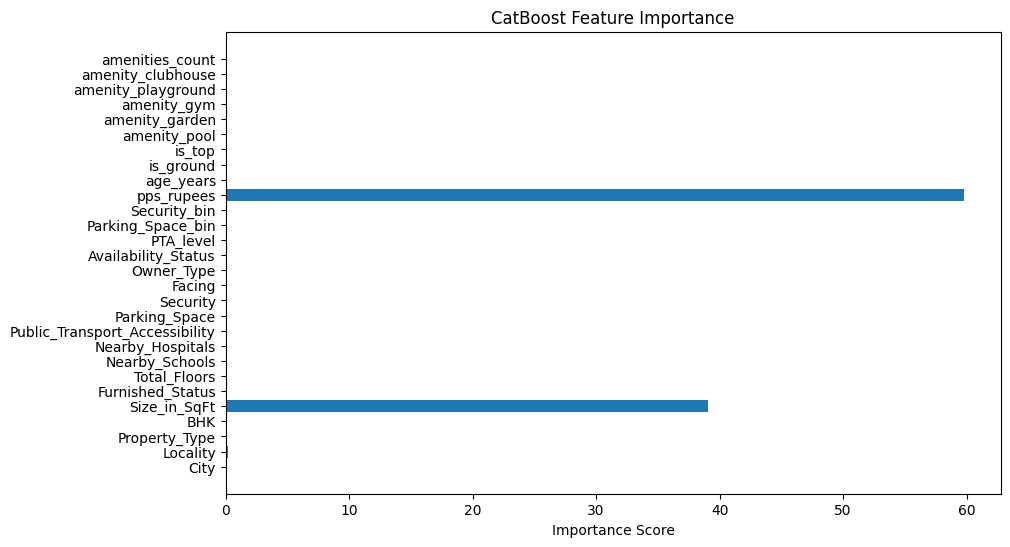

In [ ]:
# 1) Feature Importance (CatBoost built-in)

importances = final_model.get_feature_importance()
feat_names = X.columns

plt.figure(figsize=(10,6))
plt.barh(feat_names, importances)
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance Score")
plt.show()

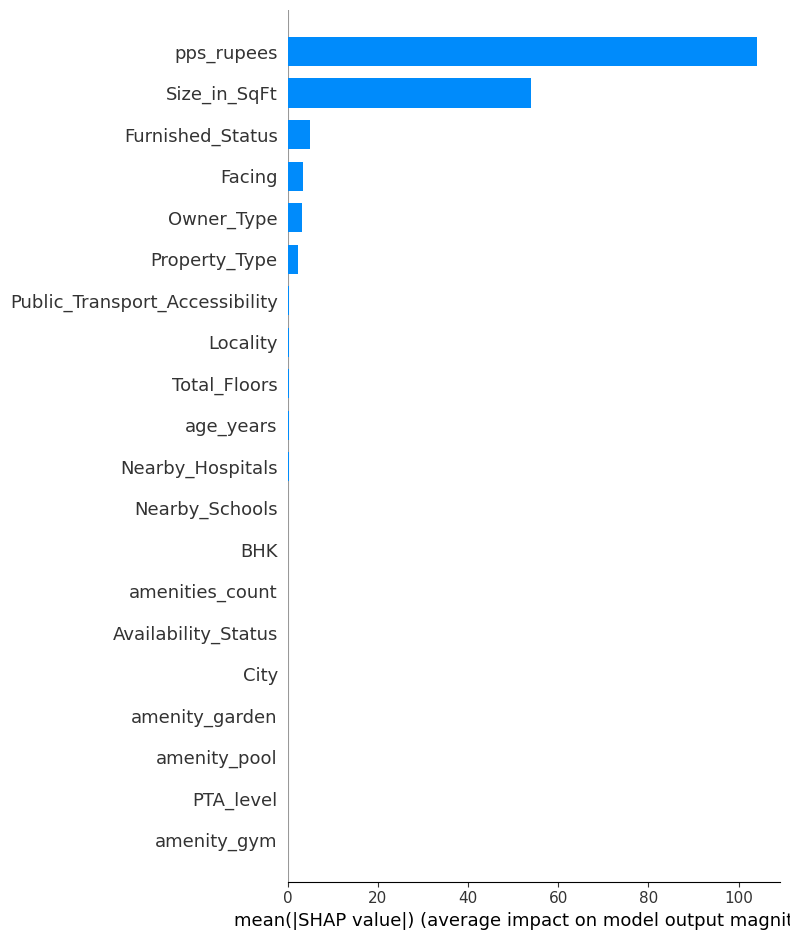

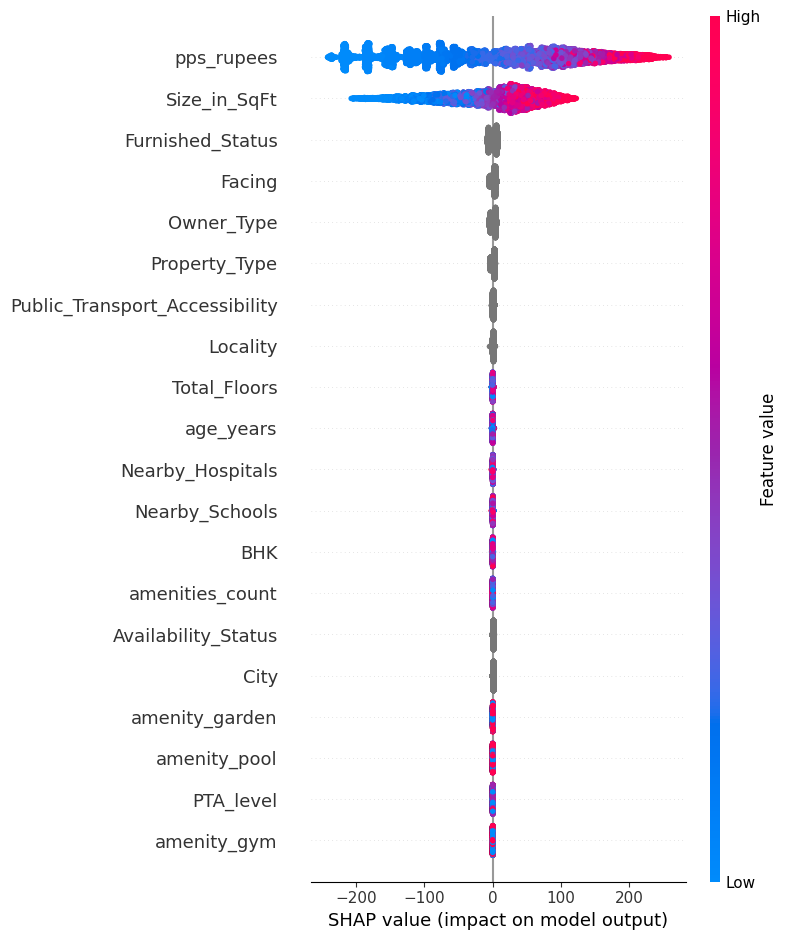

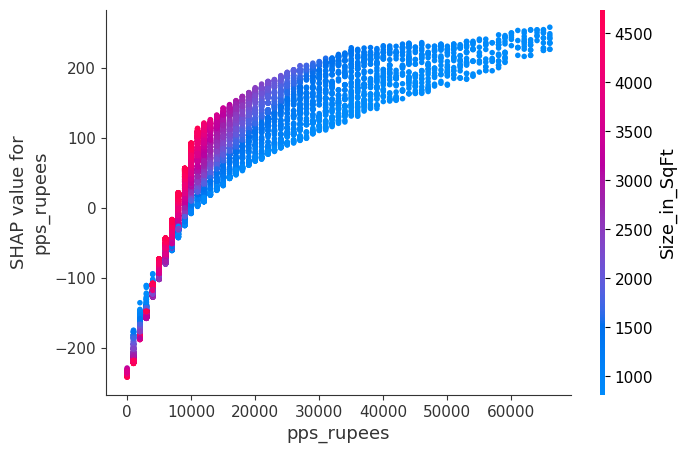

In [ ]:
# 2) SHAP Explainability

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)

# Summary Plot (global feature impact)
shap.summary_plot(shap_values, X, plot_type="bar")
shap.summary_plot(shap_values, X)

# Dependence Plot (example for top feature)
top_feat = X.columns[importances.argmax()]  # most important feature
shap.dependence_plot(top_feat, shap_values, X)